# Day 3: Cross-Validation for Time Series
## Week 4: Machine Learning Foundations

---

### 🎯 Learning Objectives
- Understand why standard CV fails for time series
- Implement walk-forward validation
- Use expanding and sliding windows
- Avoid look-ahead bias

**NEVER let future information into your training data. Ever.**

---

### The Golden Rule

### 📈 Why Proper Cross-Validation Matters in Trading

| **Sliding Window** | Fixed-size moving window | Captures regime changes |

**The Fatal Mistake:** Using standard k-fold CV on time series data gives wildly optimistic results.| **Expanding Window** | Training window grows over time | More stable |

| **Walk-Forward** | Train on past, test on immediate future | Most realistic |

**The Problem:** K-fold uses FUTURE data to predict PAST.|--------|-------------|----------|

| Method | Description | Use Case |

### Look-Ahead Bias = Guaranteed Losses

### 🎯 Correct Time Series Validation Methods

| What Happens | Result |

|--------------|--------|| Money lost | You're fired |

| K-fold shuffles data | Future leaks into training || Deploy to live trading | Strategy fails miserably |
| Model "learns" future | Backtest looks amazing |

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()

returns = prices.pct_change().dropna()
print(f"✅ Data loaded: {prices.shape[0]} days")

log_returns = np.log(prices / prices.shift(1)).dropna()

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1254 days


## 1. Why Standard K-Fold Fails

### 🎯 The Look-Ahead Bias Problem

Standard K-Fold shuffles data, which:
- Uses **future data** to predict the **past**

- Creates **look-ahead bias****K-Fold inflates performance by 5-10x or more!**

- Gives **overly optimistic** performance estimates

| Time Series CV | 0-2% | 0-2% |

### Concrete Example| K-Fold CV | 5-10% | < 0% |

|--------|------------|------------------|

| K-Fold Does This | Reality || Method | Reported R² | Actual R² (Live) |

|------------------|--------|

| Train on 2020-2024 data | You only have 2020 data today |### Typical Performance Inflation

| Test on 2019 | You're "predicting" the past |
| Model sees COVID crash | You couldn't have known in 2019 |

In [2]:
# Demonstrate the problem
print("=" * 60)
print("THE PROBLEM WITH K-FOLD FOR TIME SERIES")
print("=" * 60)

# Create lagged features
df_features = pd.DataFrame(index=returns.index)
df_features['target'] = returns['MSFT']

# Lagged returns as features
for lag in range(1, 6):
    df_features[f'lag_{lag}'] = returns['MSFT'].shift(lag)
    df_features[f'aapl_lag_{lag}'] = returns['AAPL'].shift(lag)

df_features = df_features.dropna()

X = df_features.drop('target', axis=1).values
y = df_features['target'].values

# Standard K-Fold (WRONG for time series)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
model = Ridge(alpha=1.0)

kfold_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Time Series Split (CORRECT)
tscv = TimeSeriesSplit(n_splits=5)
ts_scores = cross_val_score(model, X, y, cv=tscv, scoring='r2')

print(f"\nK-Fold CV (WRONG):")
print(f"  Mean R²: {kfold_scores.mean():.4f} ± {kfold_scores.std():.4f}")
print(f"  Scores:  {kfold_scores.round(4)}")

print(f"\nTime Series CV (CORRECT):")
print(f"  Mean R²: {ts_scores.mean():.4f} ± {ts_scores.std():.4f}")
print(f"  Scores:  {ts_scores.round(4)}")

print(f"\n⚠️ K-Fold gives OVERLY OPTIMISTIC results!")
print(f"   Difference: {(kfold_scores.mean() - ts_scores.mean()):.4f} R²")

THE PROBLEM WITH K-FOLD FOR TIME SERIES

K-Fold CV (WRONG):
  Mean R²: 0.0034 ± 0.0049
  Scores:  [ 0.0075 -0.0049  0.0033  0.0023  0.0092]

Time Series CV (CORRECT):
  Mean R²: -0.0049 ± 0.0076
  Scores:  [-0.0185 -0.0024 -0.0065 -0.0015  0.0042]

⚠️ K-Fold gives OVERLY OPTIMISTIC results!
   Difference: 0.0084 R²


VISUALIZING CV SPLITS


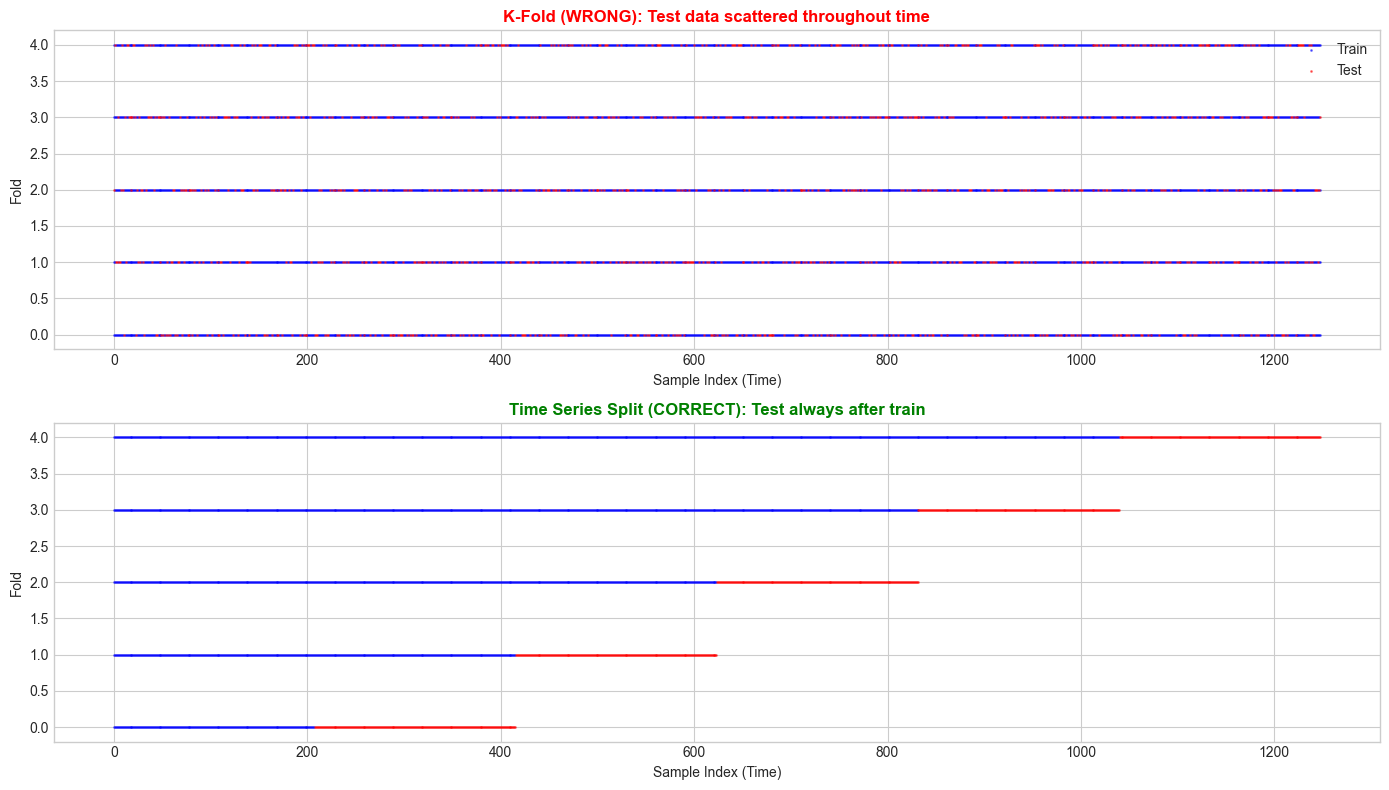

In [3]:
# Visualize the splits
print("=" * 60)
print("VISUALIZING CV SPLITS")
print("=" * 60)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

n = len(X)

# K-Fold (wrong)
ax = axes[0]
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_idx, test_idx) in enumerate(kfold.split(X)):
    ax.scatter(train_idx, [i] * len(train_idx), c='blue', s=1, alpha=0.5)
    ax.scatter(test_idx, [i] * len(test_idx), c='red', s=1, alpha=0.5)

ax.set_xlabel('Sample Index (Time)')
ax.set_ylabel('Fold')
ax.set_title('K-Fold (WRONG): Test data scattered throughout time', fontweight='bold', color='red')
ax.legend(['Train', 'Test'], loc='upper right')

# Time Series Split (correct)
ax = axes[1]
tscv = TimeSeriesSplit(n_splits=5)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    ax.scatter(train_idx, [i] * len(train_idx), c='blue', s=1, alpha=0.5)
    ax.scatter(test_idx, [i] * len(test_idx), c='red', s=1, alpha=0.5)

ax.set_xlabel('Sample Index (Time)')
ax.set_ylabel('Fold')
ax.set_title('Time Series Split (CORRECT): Test always after train', fontweight='bold', color='green')

plt.tight_layout()
plt.show()

## 2. Walk-Forward Validation

| **Embargo** | Add gap between train and test periods |

### 🎯 The Industry Standard for Trading| **Purging** | Remove overlapping samples near train/test boundary |

|-----------|--------|

**Walk-Forward mimics real trading:**| Technique | Purpose |

1. Train on historical data

2. Predict next period### Purging and Embargo (Advanced)

3. Move forward in time

4. Repeat| Step size | = test size | No overlap |

| Test size | 21-63 days | 1-3 months of out-of-sample |

### Implementation Options| Train size | 252-756 days | 1-3 years of data |

|-----------|---------------|----------|

| Method | Training Window | When to Use || Parameter | Common Values | Reasoning |

|--------|-----------------|-------------|

| **Expanding** | Grows over time | Stable relationships |### Typical Parameters

| **Sliding** | Fixed size | Regime changes expected |
| **Anchored** | Fixed start | Long-term patterns |

WALK-FORWARD VALIDATION

Walk-Forward Results (47 folds):
  Mean R²:   -0.0530
  Std R²:    0.0796
  Min R²:    -0.4336
  Max R²:    0.0075


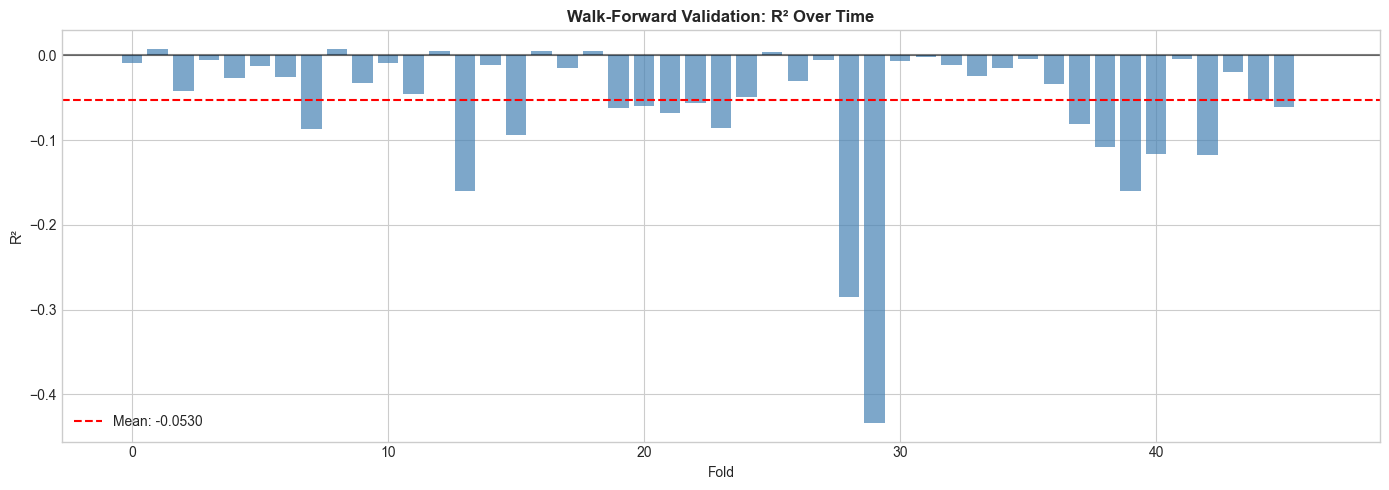

In [4]:
# Walk-forward validation
print("=" * 60)
print("WALK-FORWARD VALIDATION")
print("=" * 60)

def walk_forward_validation(X, y, model, train_size, test_size, step_size=None):
    """
    Walk-forward validation with expanding or sliding window.
    
    Parameters:
    - train_size: initial training window (or fixed for sliding)
    - test_size: how many periods to predict
    - step_size: how many periods to step forward (default = test_size)
    """
    if step_size is None:
        step_size = test_size
    
    n = len(X)
    results = []
    
    start = 0
    while start + train_size + test_size <= n:
        train_end = start + train_size
        test_end = train_end + test_size
        
        X_train = X[start:train_end]
        y_train = y[start:train_end]
        X_test = X[train_end:test_end]
        y_test = y[train_end:test_end]
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'train_start': start,
            'train_end': train_end,
            'test_start': train_end,
            'test_end': test_end,
            'mse': mse,
            'r2': r2,
            'n_train': train_end - start,
            'n_test': test_size
        })
        
        start += step_size
    
    return pd.DataFrame(results)

# Apply walk-forward
model = Ridge(alpha=1.0)
wf_results = walk_forward_validation(X, y, model, 
                                     train_size=252,  # 1 year
                                     test_size=21,    # 1 month
                                     step_size=21)    # Step 1 month

print(f"\nWalk-Forward Results ({len(wf_results)} folds):")
print(f"  Mean R²:   {wf_results['r2'].mean():.4f}")
print(f"  Std R²:    {wf_results['r2'].std():.4f}")
print(f"  Min R²:    {wf_results['r2'].min():.4f}")
print(f"  Max R²:    {wf_results['r2'].max():.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(range(len(wf_results)), wf_results['r2'], color='steelblue', alpha=0.7)
ax.axhline(wf_results['r2'].mean(), color='red', linestyle='--', label=f"Mean: {wf_results['r2'].mean():.4f}")
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Fold')
ax.set_ylabel('R²')
ax.set_title('Walk-Forward Validation: R² Over Time', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Expanding vs Sliding Window

EXPANDING vs SLIDING WINDOW

Expanding Window:
  Mean R²: -0.0522 ± 0.0825

Sliding Window:
  Mean R²: -0.0530 ± 0.0796


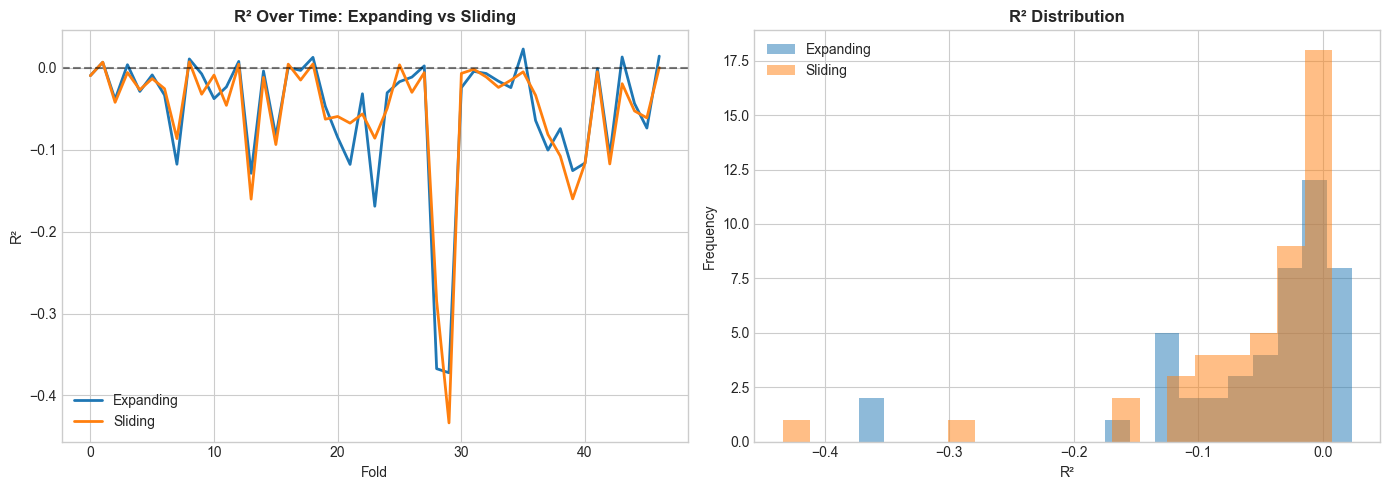


💡 Insights:
   Expanding: More data → more stable, but may include old patterns
   Sliding: Recent data only → adapts to regime changes


In [5]:
# Compare expanding vs sliding window
print("=" * 60)
print("EXPANDING vs SLIDING WINDOW")
print("=" * 60)

def expanding_window_cv(X, y, model, initial_train, test_size):
    """Expanding window: training set grows over time."""
    n = len(X)
    results = []
    
    train_end = initial_train
    while train_end + test_size <= n:
        X_train = X[:train_end]  # Expanding: always start from 0
        y_train = y[:train_end]
        X_test = X[train_end:train_end + test_size]
        y_test = y[train_end:train_end + test_size]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        results.append({'window': 'expanding', 'train_size': train_end, 'r2': r2})
        train_end += test_size
    
    return pd.DataFrame(results)

def sliding_window_cv(X, y, model, window_size, test_size):
    """Sliding window: fixed size training window."""
    n = len(X)
    results = []
    
    start = 0
    while start + window_size + test_size <= n:
        X_train = X[start:start + window_size]  # Fixed size
        y_train = y[start:start + window_size]
        X_test = X[start + window_size:start + window_size + test_size]
        y_test = y[start + window_size:start + window_size + test_size]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        
        results.append({'window': 'sliding', 'train_size': window_size, 'r2': r2})
        start += test_size
    
    return pd.DataFrame(results)

# Compare
model = Ridge(alpha=1.0)
expanding_results = expanding_window_cv(X, y, model, initial_train=252, test_size=21)
sliding_results = sliding_window_cv(X, y, model, window_size=252, test_size=21)

print(f"\nExpanding Window:")
print(f"  Mean R²: {expanding_results['r2'].mean():.4f} ± {expanding_results['r2'].std():.4f}")

print(f"\nSliding Window:")
print(f"  Mean R²: {sliding_results['r2'].mean():.4f} ± {sliding_results['r2'].std():.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² over time
axes[0].plot(expanding_results['r2'].values, label='Expanding', lw=2)
axes[0].plot(sliding_results['r2'].values, label='Sliding', lw=2)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('R²')
axes[0].set_title('R² Over Time: Expanding vs Sliding', fontweight='bold')
axes[0].legend()

# Distribution
axes[1].hist(expanding_results['r2'], bins=20, alpha=0.5, label='Expanding')
axes[1].hist(sliding_results['r2'], bins=20, alpha=0.5, label='Sliding')
axes[1].set_xlabel('R²')
axes[1].set_ylabel('Frequency')
axes[1].set_title('R² Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print("   Expanding: More data → more stable, but may include old patterns")
print("   Sliding: Recent data only → adapts to regime changes")

## 4. Hyperparameter Tuning with Time Series CV

HYPERPARAMETER TUNING WITH TIME SERIES CV

Best alpha: 1
Best CV R²: -0.0049

 param_alpha  mean_train_score  mean_test_score  std_test_score
       0.001          0.042332        -0.029389        0.045349
       0.010          0.040759        -0.022362        0.038087
       0.100          0.028833        -0.006583        0.016981
       1.000          0.009643        -0.004942        0.007598
      10.000          0.001353        -0.007140        0.007332
     100.000          0.000141        -0.007549        0.007317


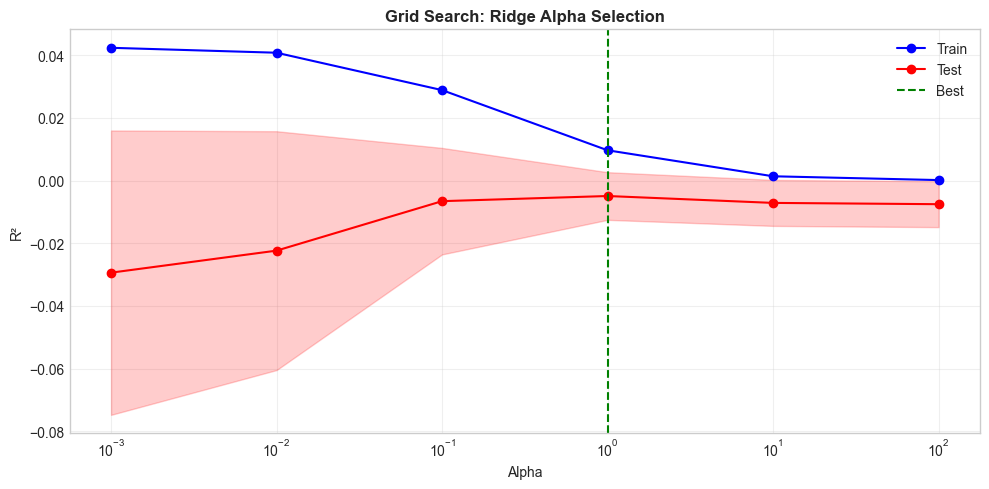

In [6]:
# Grid search with time series CV
print("=" * 60)
print("HYPERPARAMETER TUNING WITH TIME SERIES CV")
print("=" * 60)

from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Time series CV
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(
    Ridge(),
    param_grid,
    cv=tscv,
    scoring='r2',
    return_train_score=True
)

grid_search.fit(X, y)

# Results
print(f"\nBest alpha: {grid_search.best_params_['alpha']}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

# Detailed results
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha', 'mean_train_score', 'mean_test_score', 'std_test_score']]
print("\n" + results.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))

alphas = results['param_alpha'].values
ax.semilogx(alphas, results['mean_train_score'], 'b-o', label='Train')
ax.semilogx(alphas, results['mean_test_score'], 'r-o', label='Test')
ax.fill_between(alphas, 
                results['mean_test_score'] - results['std_test_score'],
                results['mean_test_score'] + results['std_test_score'],
                alpha=0.2, color='red')
ax.axvline(grid_search.best_params_['alpha'], color='green', linestyle='--', label='Best')
ax.set_xlabel('Alpha')
ax.set_ylabel('R²')
ax.set_title('Grid Search: Ridge Alpha Selection', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 📝 Key Takeaways - Day 3

### Never Use Standard K-Fold for Time Series!
- Creates look-ahead bias
- Gives unrealistic performance estimates

### Time Series CV Methods:

| Method | Training Data | Pros | Cons |
|--------|---------------|------|------|
| Expanding | All past | More stable | May include old regimes |
| Sliding | Fixed window | Adapts to changes | Less data |
| Walk-Forward | Flexible | Realistic | Computationally heavy |

### Best Practices:
1. Always respect temporal order
2. Train on past, test on future
3. Use multiple test periods for robustness
4. Consider regime changes when choosing window size

### Interview Questions:
- "Why can't you use K-Fold for time series?"
- "Explain walk-forward validation"
- "When would you use expanding vs sliding window?"

## 🔴 PROS & CONS: Cross Validation

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [7]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Cross Validation Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-22 13:41

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $247.65
   GOOGL: $328.38
   GS: $953.01
   JPM: $302.04
   MSFT: $444.11

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -8.61%
   🟢 GOOGL: +6.00%
   🟢 GS: +6.01%
   🔴 JPM: -6.09%
   🔴 MSFT: -8.42%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟢 BULLISH - Consider long positions
   GS: 🟢 BULLISH - Consider long positions
   JPM: 🔴 BEARISH - Consider reducing exposure
   MSFT: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
